In [ ]:
# Only run when notebook is opened
which_data_old = ""

In [4]:
import sys
import os
import numpy as np
import json
import glob
from tqdm import tqdm
from scipy.spatial import cKDTree as KDTree
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import vq, kmeans, whiten

from stm.feature.peaks import find_local_peaks
from temnn.data.mods import local_normalize
import tensorflow.keras as keras

from peakfitting.fit import get_parameters, gauss

%matplotlib inline
import matplotlib.pyplot as plt
print(os.getcwd())


/home/niflheim/s192943/bachelor/NeuralNetwork_HRTEM/Notebooks


# Load data

In [6]:

which_data = "test_params_MoS2_layers_8"
# which_data = "experimental_data_high_temp"

data_dir  = "../workflow/simulation_data/" + which_data + "-test/fitting_parameters/"
# data = np.load(data_dir + "fit_params.npz", allow_pickle=True)
try:
#     data_dir = "workflow/simulation_data/moreconfigs-test/fitting_parameters/"
    data = np.load(data_dir+"fit_params.npz", allow_pickle=True)
except FileNotFoundError:
#     data_dir = "../workflow/simulation_data/moreconfigs-test/fitting_parameters/"
    data = np.load('../'+data_dir+"fit_params.npz", allow_pickle=True)
    
if which_data_old != which_data:
    print("New data. Must load the corresponding model.")
    # Load model
    net = "../workflow/trained_networks/" + which_data
    model_path = os.path.join(net, "model-0")
    print("CNN is: ", model_path)
    model = keras.models.load_model(model_path)

print("Done!")
which_data_old = which_data
    

Done!


In [7]:
for key in data:
    print(key)

temp
layers
sigmas_pred
sigmas_gt
peaks_pred
peaks_gt


## Load model  (moved to earlier cell)

In [8]:
# # Load model
# net = "../workflow/trained_networks/" + which_data
# model_path = os.path.join(net, "model-0")
# print("CNN is: ", model_path)
# model = keras.models.load_model(model_path)
# print("Done!")

# Definer arrays

In [9]:
temp = data["temp"]
layers = data['layers']
peaks_gt = data["peaks_gt"]
peaks_pred = data["peaks_pred"]
gt_std = data["sigmas_gt"]
pred_std = data["sigmas_pred"]
print("  layers shape: {:}\n    temp shape: {}\n   len(gt_std): {}\n len(pred_std): {}".format(layers.shape, 
                                                                                         temp.shape, 
                                                                                         len(gt_std),
                                                                                        len(pred_std)))
N = temp.shape[0]


  layers shape: (1000,)
    temp shape: (1000,)
   len(gt_std): 1000
 len(pred_std): 1000


# Konstruer array $\verb|(2,N)|$ for høj og lav gennemsnit $\sigma$

In [10]:
sigmas = np.empty(shape=(2,N))
pred_sigma = np.empty(shape=(2,N))

# files = glob.glob("../workflow/simulation_data/test_params_MoS2_layers_8-test/tem_params/parameters_000_*.json")
# files.sort()
# layers = []


for i in range(N):
    mu = gt_std[i].mean()
    
    sigmas[0, i] = gt_std[i][gt_std[i] <= mu].mean()
    sigmas[1, i] = gt_std[i][gt_std[i] > mu].mean()
    
    mu_pred = pred_std[i].mean()
    
    pred_sigma[0, i] = pred_std[i][pred_std[i] <= mu_pred].mean()
    pred_sigma[1, i] = pred_std[i][pred_std[i] > mu_pred].mean()
    
    
#     print("high: {:.2}\n".format(sigmas[1,i]))
#     _fil =  "../workflow/simulation_data/test_params_MoS2_layers_8-test/model_properties/model_properties_"+ files[i].split('_')[-1]
#     with open(_fil, 'r') as f:
#         tem_params = json.load(f)
#     layers.append(tem_params['graphitelayers'])
    
# layers = np.array(layers); print()

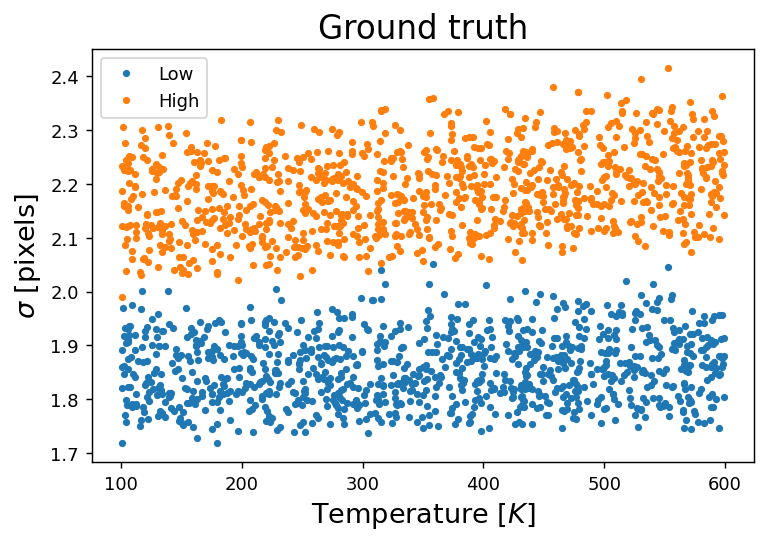

In [11]:
plt.figure(dpi=130)
plt.plot(temp, sigmas[0], '.')
plt.plot(temp, sigmas[1], '.')
plt.legend(["Low", "High"])
plt.xlabel("Temperature $[K]$", size=15)
plt.ylabel("$\sigma$ [pixels]", size=15)
plt.tight_layout()
plt.title("Ground truth", size=18)
fname = "vibration_vs_temp"
plt.savefig(fname + ".png")
plt.show()

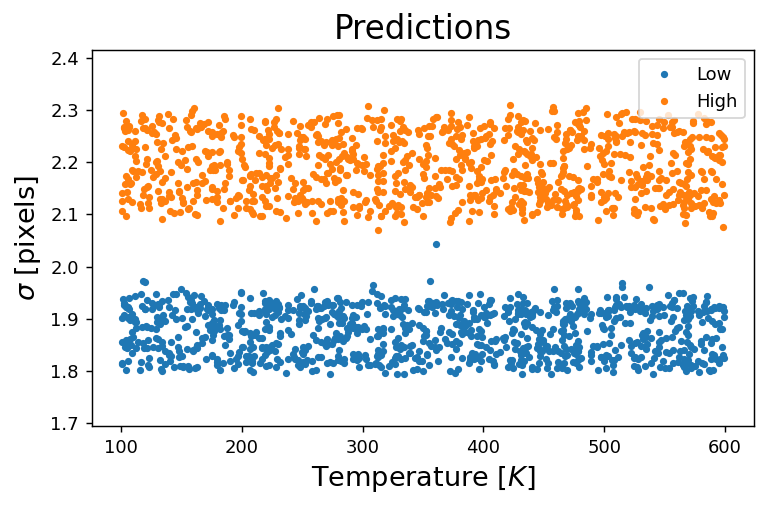

In [12]:
plt.figure(dpi=130)
plt.plot(temp, pred_sigma[0], '.')
plt.plot(temp, pred_sigma[1], '.')
plt.legend(["Low", "High"])
plt.xlabel("Temperature $[K]$", size=15)
plt.ylabel("$\sigma$ [pixels]", size=15)
plt.title("Predictions", size=18)
plt.ylim(pred_sigma.min()-0.1, sigmas.max())
plt.tight_layout()
fname = "vibration_vs_temp"
plt.savefig(fname + ".png")
plt.show()

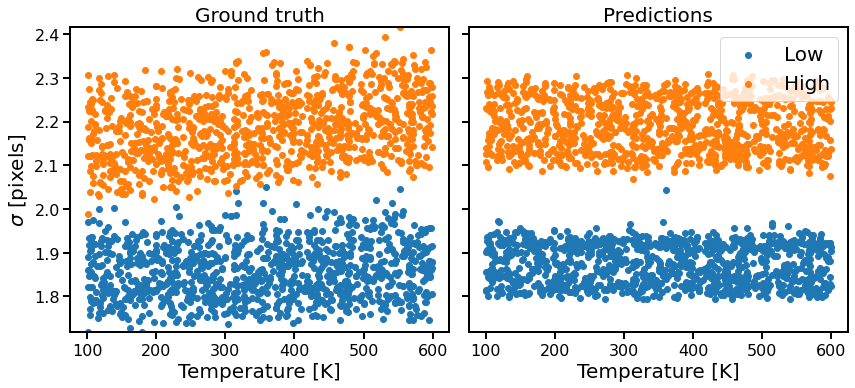

In [13]:
fontsize = 18
sharey = True

fig, axes = plt.subplots(1, 2, figsize=(12, 5.5), sharey=sharey)

mask = pred_sigma > 10
# print(pred_sigma)
# pred_sigma = pred_sigma[:, mask]
# temp = temp[:, mask]
# sigmas = sigma[:, mask]

## Plots
axes[0].set_title("Ground truth", fontsize=fontsize+2)
axes[0].scatter(temp, sigmas[0], marker='o')
axes[0].scatter(temp, sigmas[1], marker='o')


axes[1].set_title("Predictions", fontsize=fontsize+2)
axes[1].scatter(temp, pred_sigma[0], marker='o')
axes[1].scatter(temp, pred_sigma[1], marker='o')

## Labels
axes[1].legend(["Low", "High"], fontsize=fontsize+2,
#                bbox_to_anchor=(1, 1.05)
               loc="upper right"
              )


## Aspect ratio & labels
for i in (0, 1):
#     xmax = temp.max()
#     if i == 0:
#         ymax = sigmas.max()
#     else:
#         ymax = pred_sigma.max()
#     ratio = xmax / ymax
#     axes[i].set_aspect(ratio + 400)
    
    for s in axes[i].spines.values():
        s.set_linewidth(2)
    axes[i].tick_params(axis='both', which='major', labelsize=fontsize-2, length=7, width=2)
    axes[i].set_xlabel("Temperature [K]", fontsize=fontsize+2)
    if sharey is False:
        axes[i].set_ylabel("$\sigma$ [pixels]", fontsize=fontsize+2)
        
if sharey:
    axes[0].set_ylabel("$\sigma$ [pixels]", fontsize=fontsize+2)

axes[1].set_ylim(sigmas.min(), sigmas.max())

plt.tight_layout()

fname = "width_vs_temp_gt_and_pred"
plt.savefig(fname+ ".png", dpi=300)
plt.show()

### Check that they are not identical

In [14]:
np.sum(pred_sigma != sigmas, axis=1)

array([1000, 1000])

# Test of fit

In [15]:
OFFSET = 6

def show_peak(image, peak, params=False): 
    peak = peak.astype(int)
    x_range = (peak[0]-OFFSET, peak[0]+OFFSET+1)
    y_range = (peak[1]-OFFSET, peak[1]+OFFSET+1)
    if params:
        return x_range, y_range
    else:
        return image[peak[0]-OFFSET:peak[0]+OFFSET, peak[1]-OFFSET:peak[1]+OFFSET]
def get_plotvals(sub_image):
    
    x = np.linspace(0, sub_image.shape[0])
    (x0, y0, z0, A, sigma), message = get_parameters(sub_image)

    a = 1/(2*sigma**2)

    params = x0, y0, z0, A, a
    y = gauss(x, y0, *params)
    
    return (x, y), np.round(y0).astype(int)

## Load an image

In [16]:
def get_prediction(imagenumber):
    
    if type(imagenumber) is int:
        imagenumber = "{:04d}".format(imagenumber)
    
    assert type(imagenumber) is str
    
    root_dir = os.path.join(data_dir, "..")
    image_dir = os.path.join(root_dir, "images_labels")
    image_label_dir = os.path.join(image_dir, "image_label_000_{}.npz".format(imagenumber))

    tmp = np.load(image_label_dir)
    image = tmp["image"]
    label = tmp["label"]

    ## Get parameters for TEM and structures
    image_param_json = os.path.join(root_dir, "tem_params", f"parameters_000_{imagenumber}.json")
    with open(image_param_json, "r") as jsonfile:
        imageparameters = json.load(jsonfile)
    with open(os.path.join(root_dir, "parameters.json"), "r") as jsonfile:
        parameters = json.load(jsonfile)

    sampling = imageparameters["sampling"]
    normalizedistance = parameters["normalizedistance"] / sampling
    normimage = local_normalize(image.copy(), normalizedistance, normalizedistance)

    prediction = model.predict(normimage)
    return prediction

## Chose a image $n$ for which the ground truth, prediction plots show

In [17]:
n = 30
print(f"System temperature: {temp[n]}")
imagenumber = "{:04d}".format(n)
root_dir = os.path.join(data_dir, "..")
image_dir = os.path.join(root_dir, "images_labels")
image_label_dir = os.path.join(image_dir, "image_label_000_{}.npz".format(imagenumber))

tmp = np.load(image_label_dir)
image = tmp["image"]
label = tmp["label"]
print("image shape: {}\nlabel shape: {}".format(image.shape, label.shape))

# Get parameters for TEM and structures
image_param_json = os.path.join(root_dir, "tem_params", f"parameters_000_{imagenumber}.json")
with open(image_param_json, "r") as jsonfile:
    imageparameters = json.load(jsonfile)
with open(os.path.join(root_dir, "parameters.json"), "r") as jsonfile:
    parameters = json.load(jsonfile)

print("Normalizing!")
sampling = imageparameters["sampling"]
normalizedistance = parameters["normalizedistance"] / sampling
normimage = local_normalize(image.copy(), normalizedistance, normalizedistance)

print("Predicting!")
prediction = model.predict(normimage)
print("Done!")

System temperature: 140.6081108530169
image shape: (1, 640, 640, 3)
label shape: (1, 640, 640, 2)
Normalizing!
Predicting!
Done!


In [18]:
p_gt = np.sort(peaks_gt[n])
p_pred = np.sort(peaks_pred[n])

print(p_gt[:10])
print(p_pred[:10])

[[180. 428.]
 [182. 411.]
 [186. 378.]
 [188. 361.]
 [192. 328.]
 [192. 455.]
 [193. 438.]
 [194. 311.]
 [198. 277.]
 [198. 405.]]
[[179. 428.]
 [182. 411.]
 [186. 378.]
 [188. 361.]
 [191. 455.]
 [192. 327.]
 [193. 439.]
 [194. 311.]
 [197. 405.]
 [198. 277.]]


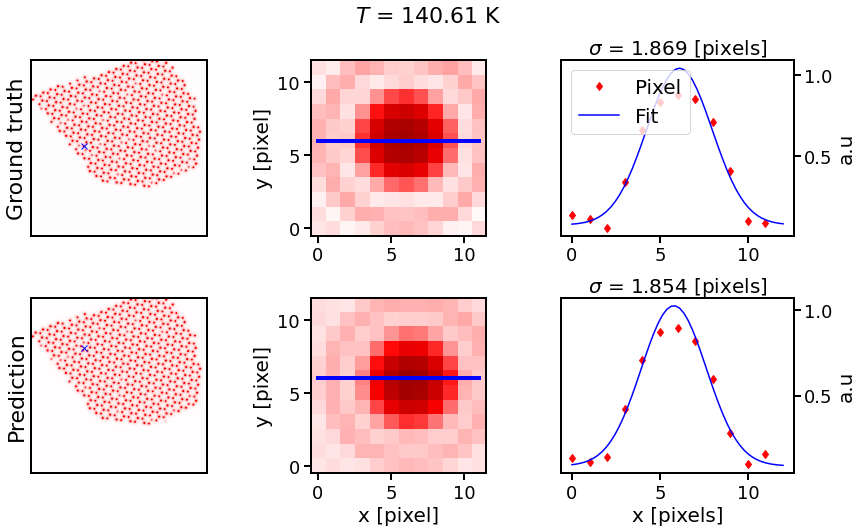

In [19]:
nth_peak = 4

fontsize=20
cmap="seismic"

maxval = max(label.max(), prediction.max())
minval = min(label.min(), prediction.min())
maxval = max(-minval, maxval)
minval = -maxval

label_real = label[...,0].squeeze()
label_imag = label[..., 1].squeeze() # 1


pred_real = prediction[..., 0].squeeze()
pred_imag = prediction[..., 1].squeeze() # 2

## Figure
fig, axes = plt.subplots(2,3, figsize=(12.5, 7.5))

for i, (imag, p, S) in enumerate(((label_imag, p_gt, gt_std[n]), (pred_imag, p_pred, pred_std[n]))):
    
#     print(imag.shape, p.shape)
    sub_image = show_peak(imag, p[nth_peak])
    
#     print(sub_image.shape)
    axes[i, 0].imshow(imag, vmin=minval, vmax=maxval, cmap=cmap, origin="lower")
    axes[i, 0].plot(*p[nth_peak], 'xb', linewidth=100)
    
#     axes[i, 0].set_xticks(range(0, imag.shape[0], 200))
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    
    
    
    x_range = np.arange(sub_image.shape[0])
    (x,y), y0 = get_plotvals(sub_image)
    
    axes[i, 1].imshow(sub_image, vmin=minval, vmax=maxval, cmap=cmap, origin="lower")
    axes[i, 1].plot(x_range, [y0]*len(x_range), linewidth=4, color='b')
    
    axes[i, 1].set_xticks(range(0, sub_image.shape[0], 5))
    axes[i, 1].set_yticks(range(0, sub_image.shape[1], 5))
    axes[i, 1].set_ylabel("y [pixel]", fontsize=fontsize)
    
    
    
    axes[i, 2].plot(x_range, sub_image[:, y0], 'dr')
    axes[i, 2].plot(x, y, 'b')
    axes[i, 2].set_ylabel("a.u", fontsize=fontsize)
    axes[i, 2].yaxis.set_label_position("right")
    axes[i, 2].yaxis.set_ticks_position("right")
    
    axes[i, 2].set_title("$\sigma$ = {:.3f} [pixels]".format(S[nth_peak]), fontsize=fontsize)




## Aspect ratio & labels
for i in range(2):
    
    for j in range(3):
        

    
        for s in axes[i, j].spines.values():
            s.set_linewidth(2)
        axes[i, j].tick_params(axis='both', which='major', labelsize=fontsize-2, length=7, width=2)


axes[1, 1].set_xlabel("x [pixel]", fontsize=fontsize)

axes[1, 2].set_xlabel("x [pixels]", fontsize=fontsize)

axes[0, 2].legend(["Pixel", "Fit"], loc="upper left", fontsize=fontsize)
axes[0, 0].set_ylabel("Ground truth", fontsize=fontsize+2)
axes[1, 0].set_ylabel("Prediction", fontsize=fontsize+2)

fig.suptitle(f"$T$ = {temp[n]:.2f} K", fontsize=fontsize+2)


plt.tight_layout()
fname = "peak_fit_gt_pred"
plt.savefig(fname+".png", dpi=300)
plt.show()

# Histogram of peak width

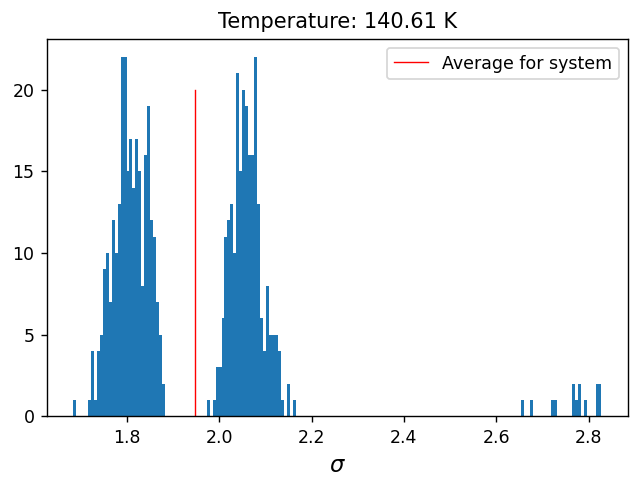

In [20]:
plt.figure(dpi=125)
# n = 52
plt.hist(gt_std[n], bins=len(gt_std[n])//3)
plt.xlabel("$\sigma$", size=13)
plt.plot([gt_std[n].mean()]*2, [0, 20], linewidth=0.8, color="r")
plt.title(f"Temperature: {temp[n]:.2f} K")
plt.legend(["Average for system"])
fname = "histogram"
plt.savefig(fname + ".png")
plt.show()

In [21]:
# for key in parameters:
#     print(key)

In [22]:
with open(os.path.join(data_dir, "../parameters.json"), 'r') as f:
    parameters = json.load(f)

T_range = parameters["Phonon_Temp"]; print("Temperature range", np.array(T_range))
sampling = np.mean(parameters["sampling"])
latconst = 3.184
distance = latconst / np.sqrt(3) / sampling
print(distance, 'pixels')


def classify(points, n, group, sublat, tree, K=4):
    sublat[n] = group
#     print(points[n])
    neighbors = tree.query(points[n], k=K,
                           distance_upper_bound=1.3*distance)[1]
    for nb in neighbors:
        if nb < len(sublat) and sublat[nb] == -1:
            classify(points, nb, not group, sublat, tree)

Temperature range [100 600]
17.507459591426368 pixels


In [23]:
# tree.query(p[startpoint], k=4, distance_upper_bound=1.3*distance)

In [24]:
# system = 0
# p = peaks_gt[system].astype(int)
# # print(p.shape)
# imagenumber = "{:04d}".format(system)
# tmp = np.load(os.path.join(data_dir, '..', "images_labels", "image_label_000_" + imagenumber+'.npz'))
# wave = tmp['label']
# pred_image = tmp['image'] # Needs to actually predict
# real = wave[..., 0].squeeze()
# imag = wave[..., 1].squeeze()

# maxval = max(real.max(), imag.max())
# minval = min(real.min(), imag.min())
# maxval = max(-minval, maxval)
# minval = -maxval
# # print(maxval)
# # print(minval)
# cmap = 'seismic'

# sublattice = - np.ones(len(p), int)
# tree = KDTree(p)
# startpoint = np.argmin(p[:,1])

# classify(p, startpoint, True, sublattice, tree)

# apeaks = p[sublattice == 1]
# bpeaks = p[sublattice == 0]
# cpeaks = p[sublattice == -1]

# theta = np.pi/2
# rotation = np.array([[np.cos(theta), np.sin(theta)],
#                      [np.sin(theta), np.cos(theta)]])

# apeaks = apeaks@rotation
# bpeaks = bpeaks@rotation
# cpeaks = cpeaks@rotation
# fig, ax = plt.subplots(1, 2, figsize=(6, 4), dpi=150)
# ax[0].imshow(real, cmap=cmap, vmin=minval, vmax=maxval, origin="lower")
# ax[0].scatter(apeaks[:, 0], apeaks[:, 1], marker="+", s=1)
# ax[0].scatter(bpeaks[:, 0], bpeaks[:, 1], marker="x", s=1)
# ax[0].scatter(cpeaks[:, 0], cpeaks[:, 1], marker="o", s=1)

# ax[1].imshow(imag, cmap=cmap, vmin=minval, vmax=maxval, origin="lower")
# ax[1].scatter(apeaks[:,0], apeaks[:,1], marker="+", s=1)
# ax[1].scatter(bpeaks[:,0], bpeaks[:,1], marker="x", s=1)
# ax[1].scatter(cpeaks[:,0], cpeaks[:,1], marker="o", s=1)
# plt.show()

In [25]:
# # 
# x, y = p[0]
# print("peak: {x, y} = {%d, %d}" %(x, y))
# plt.imshow(real[x-2:x+3, y-2:y+3])
# plt.colorbar()
# plt.show()
# plt.imshow(imag[x-2:x+3, y-2:y+3])
# plt.colorbar()
# plt.show()

In [26]:
# argand_peak = np.empty(shape=(p.shape))
# for i, (x, y) in enumerate(p):
#     if np.any(np.array((x,y)) < 1) or np.any(np.array((x,y)) > 638):
#         print(i)
#         continue
#     argand_peak[i, 0] = (real[x-1:x+2, y-1:y+2]).mean()
#     argand_peak[i, 1] = (imag[x-1:x+2, y-1:y+2]).mean()

In [27]:

# Re, Im = argand_peak.T
# plt.scatter(Re, Im)
# plt.xlabel("$\mathbb{R}$", fontsize=22)
# plt.ylabel("$\mathbb{I}$", fontsize=22)
# plt.show()

In [28]:
# centroids, *_ = kmeans(argand_peak, 3)
# print(centroids)
# # centroids = np.array([[-0.05, 0.85],
# #                      [0.0125, 0.85],
# #                      [0.0125, 0.5],
# #                      [0.1125, 0.35]])
# clx, _ = vq(argand_peak, centroids)
# plt.scatter(*argand_peak.T, c=clx)
# None

In [29]:
# for i in np.unique(clx):
# #     print(i)
#     print(argand_peak[clx == i].mean(axis=0))

In [30]:
print(T_range)

[100, 600]


# Argand plot for all systems in temperature ranges

In [31]:
# Load data
N = len(temp)
WAVES = np.empty((N, 640, 640, 2))
PRED = np.empty((N, 640, 640, 2))
for i in tqdm(range(N)):
    imagenumber = "{:04d}".format(i)
    tmp = np.load(os.path.join(data_dir, '..', "images_labels", "image_label_000_" + imagenumber+'.npz'))
    WAVES[i] = tmp['label']
    
#     print("predicting")
#     PRED[i] = get_prediction(imagenumber)
    

100%|██████████| 1000/1000 [00:25<00:00, 39.01it/s]


In [32]:
MEANS = True
K = 3
lw = 1 # linewidth of scatter plots
fontsize = 18

def define_argand(real, imag, peak):
    P = peak.astype(int)
    argand_peak = np.zeros_like((peak))
    
    for i, (x,y) in enumerate(P):
        if np.any(np.array((x,y)) < 1) or np.any(np.array((x,y)) > 638):
            continue
        argand_peak[i, 0] = (real[x-1:x+2, y-1:y+2]).mean() + 1
        argand_peak[i, 1] = (imag[x-1:x+2, y-1:y+2]).mean()
    return argand_peak
def circle(start=0, stop=90):
    v1 = start * np.pi / 180
    v2 = stop * np.pi / 180
    X = np.linspace(v1, v2)
    
    arr = np.column_stack([np.cos(X), np.sin(X)])
    return arr


In [33]:
# Which system
# n = 10
wave = WAVES[n]
print(f"System temperature: {temp[n]} K")
# image = IMAGES[n]

p = peaks_gt[n]
real, imag = wave[...,0], wave[..., 1]


System temperature: 140.6081108530169 K


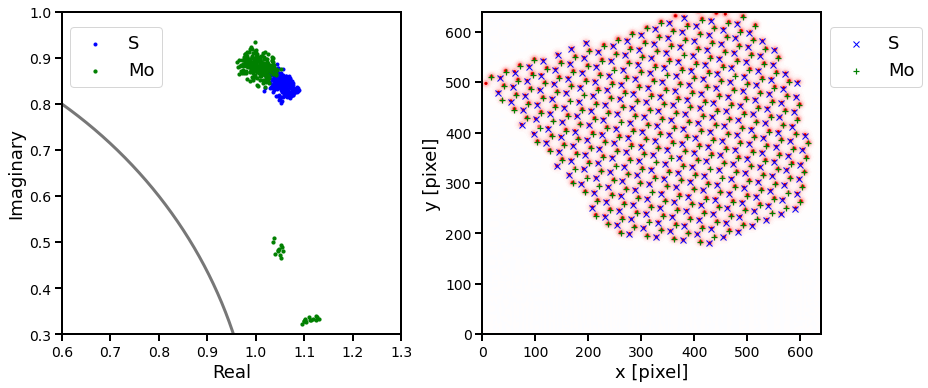

In [34]:
font_size = 18


# Find common minimal and maximal values for the three images
maxval = max(real.max(), imag.max())
minval = min(real.min(), imag.min())
maxval = max(-minval, maxval)
minval = -maxval

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5.5))


argand_peak = define_argand(real, imag, p)
        
sublattice = - np.ones(len(p), int)
tree = KDTree(p)
startpoint = np.argmin(p[:,0])

classify(p, startpoint, True, sublattice, tree, K=3)

slat = sublattice == 1
molat = sublattice == 0

ax1.scatter(argand_peak[slat, 0], argand_peak[slat, 1], marker=".", c="b", linewidth=lw)
ax1.scatter(argand_peak[molat, 0], argand_peak[molat, 1], marker=".", c="g", linewidth=lw+0.2)




ax2.scatter(p[slat, 1], p[slat, 0], marker="x", linewidth=lw, c="b")
ax2.scatter(p[molat, 1], p[molat, 0], marker="+", linewidth=lw+0.2, c="g")
ax2.imshow(imag, vmin=minval, vmax=maxval, cmap="seismic", origin="lower", aspect="auto")


ax1.set_xlabel('Real', fontsize=fontsize)
ax1.set_ylabel('Imaginary', fontsize=fontsize)

ax2.set_xlabel("x [pixel]", fontsize=fontsize)
ax2.set_ylabel("y [pixel]", fontsize=fontsize)

ax1.tick_params(axis='both', which='major', labelsize=14, length=7, width=2)
ax2.tick_params(axis='both', which='major', labelsize=14, length=7, width=2)




for s in ax1.spines.values():
    s.set_linewidth(2)
for s in ax2.spines.values():
    s.set_linewidth(2)
legend = ["S", "Mo"]
ax1.legend(legend, fontsize=fontsize, bbox_to_anchor=(0.32, 0.98))
ax2.legend(legend, fontsize=fontsize, bbox_to_anchor=(1, 0.98))

## Add unit circle
angl = np.linspace(0, np.pi/2, 500)
uc_x = np.cos(angl)
uc_y = np.sin(angl)
ax1.plot(uc_x, uc_y, linewidth=3, color='#777777')
ax1.set_xlim(0.6, 1.3)
ax1.set_ylim(0.3, 1.0)
plt.tight_layout()

fname = "argand_single_system_gt"
fig.savefig(fname + '.png', bbox_inches='tight', dpi=300)

plt.show()

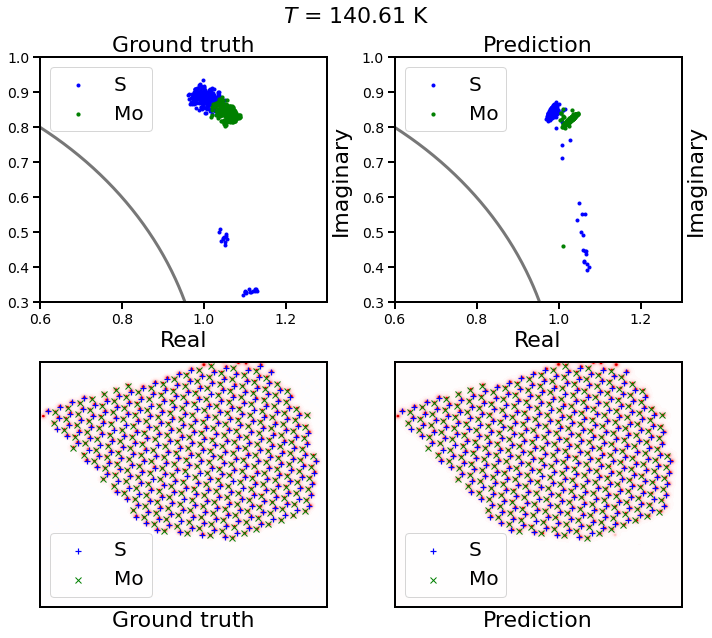

In [35]:
fontsize=20

cmap="seismic"

maxval = max(label.max(), prediction.max())
minval = min(label.min(), prediction.min())
maxval = max(-minval, maxval)
minval = -maxval

label_real = label[...,0].squeeze()
label_imag = label[..., 1].squeeze() # 1


pred_real = prediction[..., 0].squeeze()
pred_imag = prediction[..., 1].squeeze() # 2


## Begin figure
fig, axes = plt.subplots(2,2, figsize=(10, 9))
p_gt = peaks_gt[n]
p_pred = peaks_pred[n]


angl = np.linspace(0, np.pi/2, 500)
uc_x = np.cos(angl)
uc_y = np.sin(angl)

for i, (real, imag, p) in enumerate( ((label_real, label_imag, p_gt), (pred_real, pred_imag, p_pred)) ):
    
    argand_peak = define_argand(real, imag, p)
    
    sublattice = - np.ones(len(p), int)
    tree = KDTree(p)
    startpoint = np.argmin(p[:,0])

    classify(p, startpoint, True, sublattice, tree, K=3)

    slat = sublattice == 0
    molat = sublattice == 1
    
    axes[0, i].scatter(argand_peak[slat, 0], argand_peak[slat, 1], marker=".", c="b", linewidth=lw)
    axes[0, i].scatter(argand_peak[molat, 0], argand_peak[molat, 1], marker=".", c="g", linewidth=lw+0.2)
    
    axes[0, i].legend(["S", "Mo"], fontsize=fontsize)
    axes[0, i].plot(uc_x, uc_y, linewidth=3, color='#777777')
    axes[0, i].set_xlim(0.6, 1.3)
    axes[0, i].set_ylim(0.3, 1.0)
    
    
    axes[0, i].set_ylabel("Imaginary", fontsize=fontsize+2)
    axes[0, i].yaxis.set_label_position("right")
    axes[0, i].set_xlabel("Real", fontsize=fontsize+2)
    
    
    
    axes[1, i].scatter(p[slat, 1], p[slat, 0], marker="+", linewidth=lw+0.2, c="b")
    axes[1, i].scatter(p[molat, 1], p[molat, 0], marker="x", linewidth=lw, c="g")
    axes[1, i].imshow(imag, vmin=minval, vmax=maxval, cmap="seismic", origin="lower", aspect="auto")
    
    axes[1, i].legend(["S", "Mo"], fontsize=fontsize, loc="lower left")
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    
for i in range(2):
    for j in range(2):
        axes[i,j].tick_params(axis='both', which='major', labelsize=14, length=7, width=2)
        for s in axes[i,j].spines.values():
            s.set_linewidth(2)


axes[0, 0].set_title("Ground truth", fontsize=fontsize+2)
axes[0, 1].set_title("Prediction", fontsize=fontsize+2)

axes[1, 0].set_xlabel("Ground truth", fontsize=fontsize+2)
axes[1, 1].set_xlabel("Prediction", fontsize=fontsize+2)

fig.suptitle(f"$T$ = {temp[n]:.2f} K", fontsize=fontsize+2)
   
plt.tight_layout()

fname = "Argand_gt_pred"
plt.savefig(fname+".png", dpi=300)
plt.show()

# Argand plot of single system

100%|██████████| 204/204 [00:06<00:00, 30.34it/s]


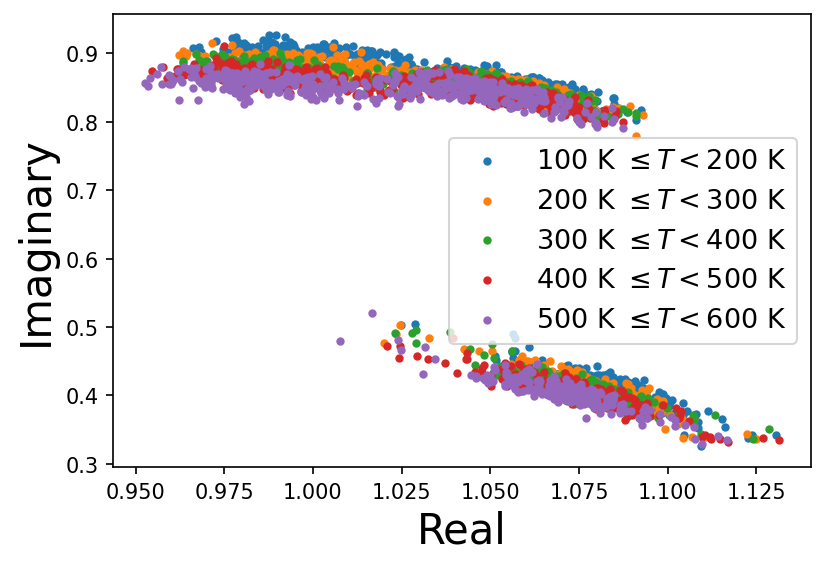

In [89]:


# def rotate(array, degrees):
#     v = degrees * np.pi / 180
#     M = np.array([[np.cos(v), -np.sin(v)],
#                   [np.sin(v),  np.cos(v)]])
#     return array@M

for m in range(*np.array(T_range) // 100):
    mask = (temp >= 100*m)*(temp  < 100*(m+1))
    systems_peaks = peaks_gt[mask]
    systems_waves = WAVES[mask]
    N = len(systems_peaks)
    centroids = []
#     lattice = []
    for n in tqdm(range(N)):
        system_n_peak = systems_peaks[n]
        system_n_wave = systems_waves[n]
        real = system_n_wave[..., 0]
        imag = system_n_wave[..., 1]
        
        
        argand_peak = define_argand(real, imag, system_n_peak)
        
        sublattice = - np.ones(len(system_n_peak), int)
        tree = KDTree(system_n_peak)
        startpoint = np.argmin(system_n_peak[:,1])

        classify(system_n_peak, startpoint, True, sublattice, tree, K=K)
        
#         lattice.append(sublattice)
        
        cent, *_ = kmeans(argand_peak, K)
        
        # Make subplot of the first system
#         if (n == 0) and (m == T_range[0] //100):
            
#             maxval = max(real.max(), imag.max())
#             minval = min(real.min(), imag.min())
#             maxval = max(-minval, maxval)
#             minval = -maxval
            
#             slat = sublattice == 0
#             molat = sublattice == 1
            
#             argand_mo = argand_peak[molat]
#             argand_s = argand_peak[slat]
#             mopeak = system_n_peak[molat]
#             speak = system_n_peak[slat] 
            
#             fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
#             ax[0].scatter(argand_mo[:,0], argand_mo[:, 1], marker='+', linewidth=lw+.2, c="g")
#             ax[0].scatter(argand_s[:, 0], argand_s[:, 1], marker="x", linewidth=lw, c="b")
            
#             ax[1].imshow(imag, vmin=minval, vmax=maxval, cmap="seismic", origin="lower", aspect="auto")
#             ax[1].scatter(speak[:, 1], speak[:, 0], marker="+", linewidth=lw+0.2, c="g")
#             ax[1].scatter(mopeak[:, 1], mopeak[:, 0], marker="x", linewidth=lw, c="b")
#             legend = ["Mo", "S"]
#             if not np.sum(argand_peak[sublattice == -1] ) == 0:
#                 ax[0].scatter(*argand_peak[sublattice == -1].T, marker=".")
#                 legend += ["Error"]
# #             print(argand_peak[sublattice == -1])
#             fig.legend(legend, fontsize=fontsize, bbox_to_anchor=(1.16, .97))
#             ax[0].set_xlabel("Real", size=fontsize)
#             ax[0].set_ylabel("Imaginary", size=fontsize)
            
#             ax[1].set_xlabel("x [pixels]", size=fontsize)
#             ax[1].set_ylabel("y [pixels]", size=fontsize)
            
#             circ = circle(0,90)
#             ax[0].plot(circ[:,0], circ[:,1], 'k')
#             ax[0].set_xlim([0.6, 1.2])
#             ax[0].set_ylim([0, 1])
            
#             plt.tight_layout()
#             fname = "argand_single_system"
#             fig.savefig(fname + '.png', bbox_inches='tight')
#             plt.show()
            
        centroids.extend(cent)
#     lattice = np.asarray(lattice)
#     print(type(lattice), lattice.shape)
    centroids = np.asarray(centroids)
    
#     print("({}*{}, {})".format(centroids.shape[0] // K, K, centroids.shape[1]))
    Re, Im = centroids.T
    if not MEANS:
        c, *_ = kmeans(centroids, K)
        Re, Im = c.T
    if m == 1:
        plt.figure()
    plt.scatter(Re, Im, marker=".", linewidth=lw)
#     break
legend = ["{} K $\leq T <${} K".format(i*100, (i+1)*100) for i in range(*np.array(T_range) // 100)]
plt.legend(legend, fontsize=13)
plt.xlabel("Real", size=fontsize)
plt.ylabel("Imaginary", size=fontsize)
fname = "argand_all_systems"
plt.savefig(fname + ".png", bbox_inches='tight', dpi=300)
plt.show()

# Test